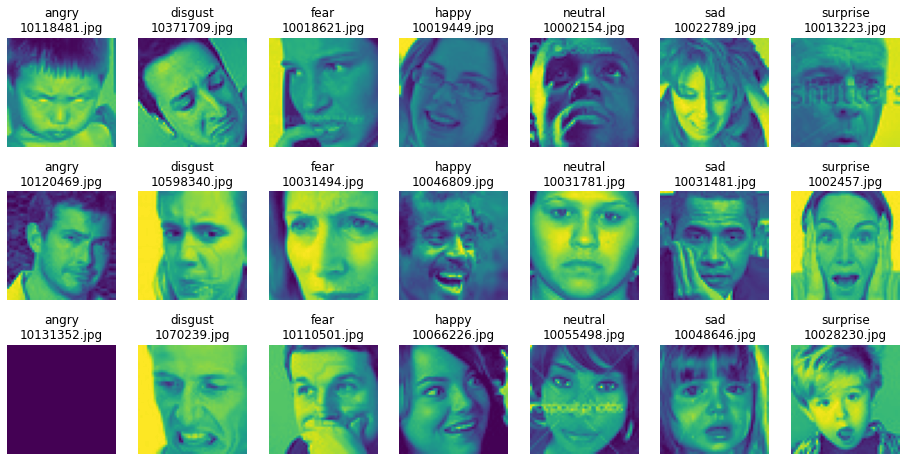

In [2]:
# from Kaggle https://www.kaggle.com/msambare/fer2013

import matplotlib.pyplot as plt
import os

n_samples = 3
img_dim = None

expressions = os.listdir(os.path.join(os.curdir, 'train'))
_, axes = plt.subplots(nrows=n_samples, ncols=len(expressions), figsize=(16, 8))

for i, category in enumerate(expressions):
    for _, _, files in os.walk(f'train/{category}'):
        for j in range(n_samples):
            ax = axes[j][i]
            img = plt.imread(f'train/{category}/{files[j]}')
            img_dim = img.shape
            _, id = files[j].split('_')
            ax.imshow(img)
            ax.set_title(f'{category}\n{id}')
            ax.axis('off')

plt.show()

In [3]:
from tensorflow.keras import callbacks, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
def new_img_generator(directory, img_dim, split=False):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=.2)
    flow_fn = lambda subset: datagen.flow_from_directory(
        directory,
        subset=subset,
        target_size=img_dim,
        batch_size=32,
        class_mode='categorical')
    
    return flow_fn(None) if split == False else (flow_fn('training'), flow_fn('validation'))

In [5]:
def build_conv2d_model(n_classes, img_dim, n_neurons=50, n_convd_layers=1, n_dense_layers=1):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=img_dim + (3,)))
    
    for i in range(n_convd_layers):
        model.add(layers.Conv2D(filters=32 * (i + 1), kernel_size=3, activation='relu'))
        model.add(layers.MaxPool2D(pool_size=2))
        
    model.add(layers.Flatten())
    
    for _ in range(n_dense_layers):
        model.add(layers.Dense(n_neurons, activation='relu'))
        
    model.add(layers.Dense(n_classes, activation='softmax'))
 
    model.compile(
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        optimizer='sgd'
    )
    
    return model

In [6]:
model = build_conv2d_model(len(expressions), img_dim)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 16928)             0         
                                                                 
 dense (Dense)               (None, 50)                846450    
                                                                 
 dense_1 (Dense)             (None, 7)                 357       
                                                                 
Total params: 847,703
Trainable params: 847,703
Non-trainable params: 0
__________________________________________________

In [24]:
from functools import partial

def build_and_train_model_fn(n_classes, img_dim, n_convd_layers, n_dense_layers, n_neurons):
    model = build_conv2d_model(n_classes, img_dim,
                               n_convd_layers=n_convd_layers,
                               n_dense_layers=n_dense_layers,
                               n_neurons=n_neurons)
    
    trainX_gen, valX_gen = new_img_generator('train', img_dim, split=True)
    early_stopping_cb = callbacks.EarlyStopping(monitor='val_loss', patience=5)

    history = model.fit(trainX_gen, epochs=50, validation_data=valX_gen, callbacks=[early_stopping_cb])
    
    return model, history


def plot_training_history(history, n_convd_layers, n_dense_layers, n_neurons):
    epochs = range(len(history.history['accuracy']))
    plt.figure(figsize=(12, 8))

    for label, representation in zip(history.history.keys(), ['b-', 'g-', 'r-', 'y-']):
        plt.plot(epochs, history.history[label], representation, label=label)
    
    title = f'{n_convd_layers} Conv2D and {n_dense_layers} Dense with {n_neurons} neurons each'
    plt.title(title)
    plt.legend(loc='center left')
    plt.show()
   

build_and_train_model = partial(build_and_train_model_fn, len(expressions), img_dim)

In [7]:
model, history = build_and_train_model(1, 1, 50)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Epoch 1/50
718/718 [==============================] - 11s 12ms/step - loss: 1.7945 - accuracy: 0.2614 - val_loss: 1.7655 - val_accuracy: 0.2890
Epoch 2/50
718/718 [==============================] - 8s 12ms/step - loss: 1.7109 - accuracy: 0.3254 - val_loss: 1.6748 - val_accuracy: 0.3421
Epoch 3/50
718/718 [==============================] - 8s 12ms/step - loss: 1.6389 - accuracy: 0.3641 - val_loss: 1.6330 - val_accuracy: 0.3759
Epoch 4/50
718/718 [==============================] - 9s 12ms/step - loss: 1.5826 - accuracy: 0.3930 - val_loss: 1.5915 - val_accuracy: 0.3832
Epoch 5/50
718/718 [==============================] - 8s 12ms/step - loss: 1.5346 - accuracy: 0.4139 - val_loss: 1.5482 - val_accuracy: 0.4059
Epoch 6/50
718/718 [==============================] - 9s 12ms/step - loss: 1.4912 - accuracy: 0.4373 - val_loss: 1.5204 - val_accuracy: 0.4222
Epoch 7/50
718/718 [==============================] - 8s

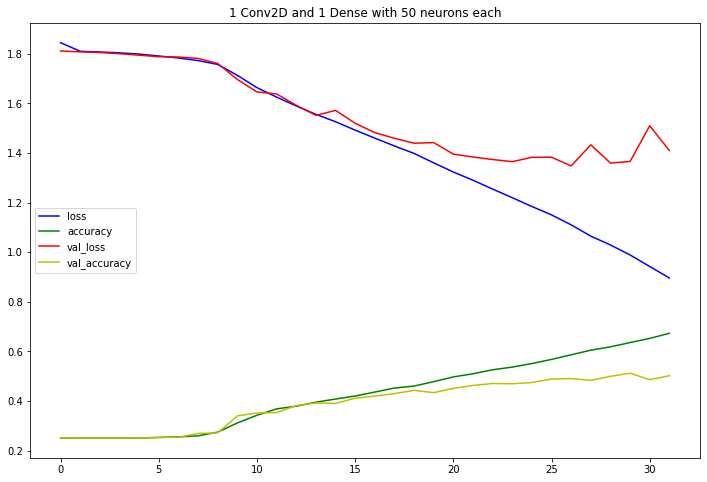

In [22]:
plot_training_history(history, 1, 1, 50)

In [7]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

keras_clf = KerasClassifier(build_fn=build_conv2d_model)

param_grid = {
    'n_convd_layers': range(1, 5),
    'n_dense_layers': range(1, 100),
    'n_neurons': range(50, 201, 25)
}

trainX_gen, valX_gen = new_img_generator('train', img_dim, split=True)
early_stopping_cb = callbacks.EarlyStopping(monitor='val_loss', patience=5)

clf = RandomizedSearchCV(model=keras_clf, param_distributions=param_grid, scoring='accuracy', random_state=42)
clf.fit(trainX_gen, epochs=100, validation_data=valX_gen, callbacks=[early_stopping_cb])

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


ValueError: Invalid parameter n_neurons for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(n_neurons=200)`
Check the list of available parameters with `estimator.get_params().keys()`

In [20]:
from tensorflow.keras.applications import Xception

resized_dim = (img_dim[0] * 2, img_dim[1] * 2)

xception = Xception(include_top=False, input_shape=resized_dim + (3,), classes=len(expressions))
xception.trainable = False

model = models.Sequential([
    layers.InputLayer(input_shape=img_dim + (3,)),
    layers.Resizing(resized_dim[0], resized_dim[1]),
    layers.Rescaling(1./255),
    xception,
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(len(expressions), activation='softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 96, 96, 3)         0         
                                                                 
 rescaling_3 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 flatten_4 (Flatten)         (None, 18432)             0         
                                                                 
 dense_11 (Dense)            (None, 100)               1843300   
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dense_13 (Dense)            (None, 7)                

In [21]:
model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='adam'
)
trainX_gen, valX_gen = new_img_generator('train', img_dim, split=True)
early_stopping_cb = callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(trainX_gen, epochs=50, validation_data=valX_gen, callbacks=[early_stopping_cb])

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Epoch 1/50
718/718 [==============================] - 553s 764ms/step - loss: 1.8126 - accuracy: 0.2487 - val_loss: 1.7998 - val_accuracy: 0.2513
Epoch 2/50
718/718 [==============================] - 83s 115ms/step - loss: 1.7856 - accuracy: 0.2616 - val_loss: 1.7742 - val_accuracy: 0.2637
Epoch 3/50
718/718 [==============================] - 83s 115ms/step - loss: 1.7599 - accuracy: 0.2770 - val_loss: 1.7515 - val_accuracy: 0.2865
Epoch 4/50
718/718 [==============================] - 82s 114ms/step - loss: 1.7434 - accuracy: 0.2840 - val_loss: 1.7348 - val_accuracy: 0.2914
Epoch 5/50
718/718 [==============================] - 82s 114ms/step - loss: 1.7309 - accuracy: 0.2941 - val_loss: 1.7368 - val_accuracy: 0.2982
Epoch 6/50
718/718 [==============================] - 83s 115ms/step - loss: 1.7170 - accuracy: 0.3040 - val_loss: 1.7241 - val_accuracy: 0.2994
Epoch 7/50
718/718 [========================